In [1]:
import os
import re
import shutil
import sys
from datetime import date

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

from utils import *
from deconv import *

In [2]:
%matplotlib notebook
plt.rcParams.update({"figure.max_open_warning": 0})

## Example Bipolar Data (2021_06_30)
### In each table:                                                             
* column 1 & 2 : static spot stimulus_200um (two trials)                       
* column 3 & 4 : snake stimulus_500um/s (two trials)                           
* column 5 & 6 : moving spot stimulus_500um/s (two trials)                     

**Scan rate for all**: 58.25 Hz                                                
**ROI size**: 5 um.

In [3]:
base_path = "/mnt/Data/prerna_velocity/"
data_path = os.path.join(base_path, "2021_06_30/waveforms/")
stim_labels = ["static_spot", "snake", "moving_spot"]
n_trials = 2
hz = 58.25
dt = 1 / hz

roi_data = {
    d: np.stack(
        [
            pd.read_csv(os.path.join(data_path, d, f), skiprows=1).values.T
            for f in os.listdir(os.path.join(data_path, d))
        ], 
        axis=0
    ) 
    for d in ["DD", "PD"]
}

recs = {
    d: {
        s: rois[:, i * n_trials:i * n_trials + n_trials]
        for i, s in enumerate(stim_labels)
    }  
    for d, rois in roi_data.items()
}

normed = {
    d: {s: rs / np.max(rs, axis=2, keepdims=True) for s, rs in rois.items()} 
    for d, rois in recs.items()
}

avg_recs = {
    d: {s: np.mean(rs, axis=1) for s, rs in rois.items()} 
    for d, rois in recs.items()
}

avg_normed = {
    d: {s: np.mean(rs, axis=1) for s, rs in rois.items()} 
    for d, rois in normed.items()
}


def aligned_avg_old(avg_recs, bsln_end=100, window=5, order=3):
    filtered = np.stack([savgol_filter(r, window, order) for r in avg_recs], axis=0)
    max_idxs = np.argmax(filtered[:, bsln_end:], axis=1) + bsln_end
    shifts = max_idxs - np.min(max_idxs)
    trim = np.max(shifts)
    aligned = np.mean(
        [r[s:(-trim + s) if s != trim else None] for r, s in zip(avg_recs, shifts)],
        axis=0
    )
    return aligned

def aligned_avg(avg_recs, bsln_start=50, bsln_end=150, step=1):
    rise_idxs = np.array([
            find_rise_bsln(r, bsln_start=bsln_start, bsln_end=bsln_end, step=step)
            for r in avg_recs
        ])
    shifts = rise_idxs - np.min(rise_idxs)
    trim = np.max(shifts)
    aligned = np.mean(
        [r[s:(-trim + s) if s != trim else None] for r, s in zip(avg_recs, shifts)],
        axis=0
    )
    return aligned

aligned_recs = {
    d: {s: aligned_avg(rs) for s, rs in rois.items()}
    for d, rois in avg_recs.items()
}

aligned_normed = {
    d: {s: aligned_avg(rs) for s, rs in rois.items()}
    for d, rois in avg_normed.items()
}

n_rois, n_trials, n_pts = recs["DD"]["snake"].shape
rec_xaxis = np.arange(n_pts) * dt

### Data Overview (plots of all ROIs for both scan-fields)

<IPython.core.display.Javascript object>


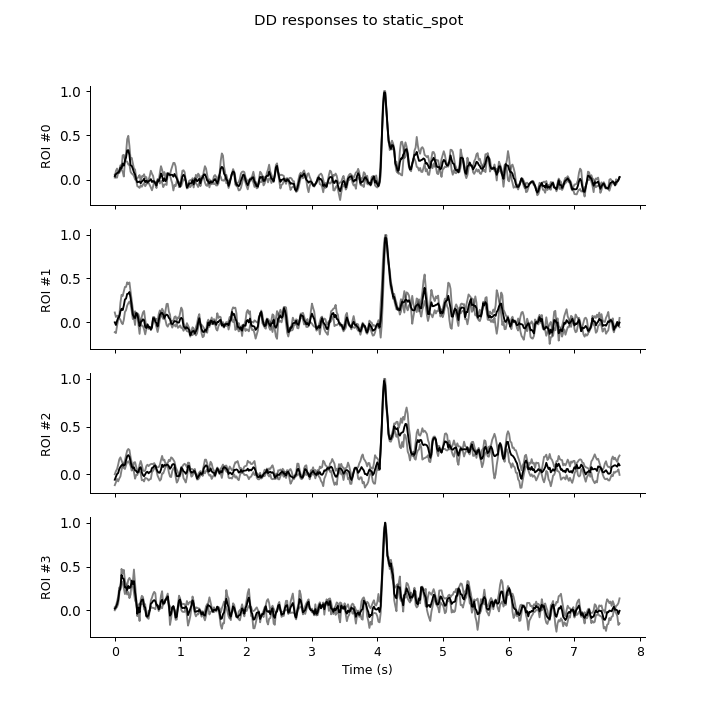

<IPython.core.display.Javascript object>


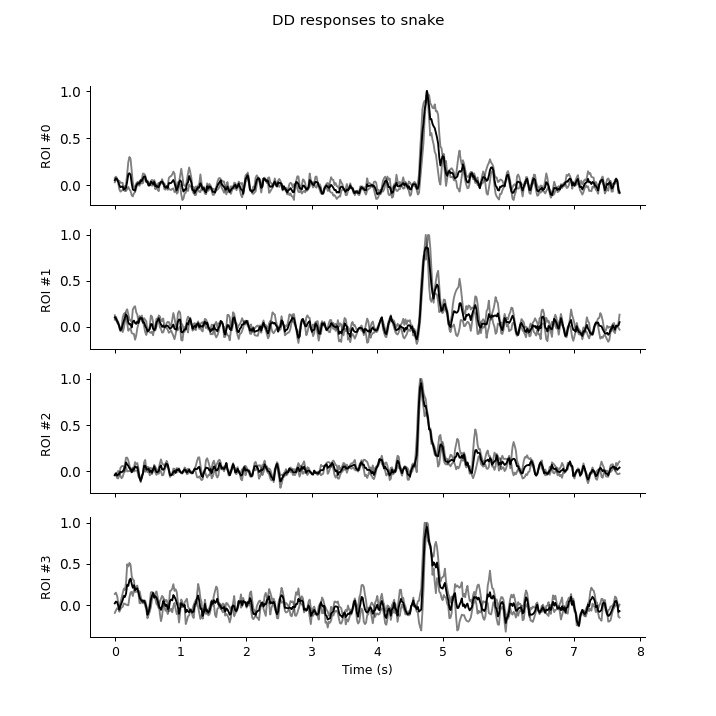

<IPython.core.display.Javascript object>


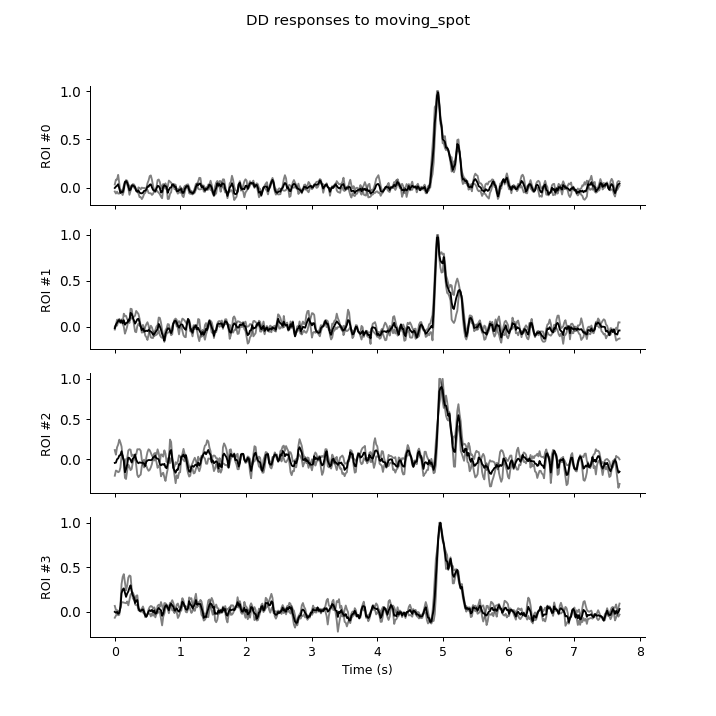

<IPython.core.display.Javascript object>


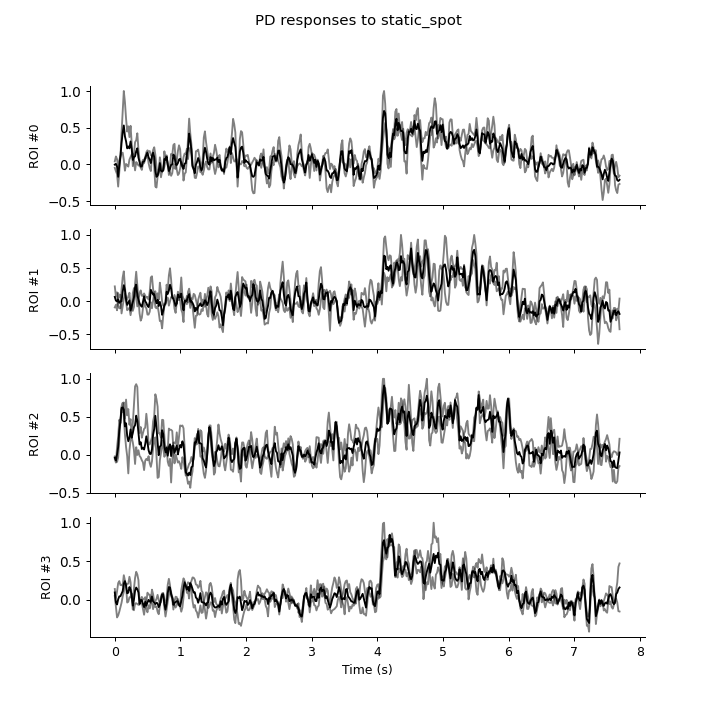

<IPython.core.display.Javascript object>


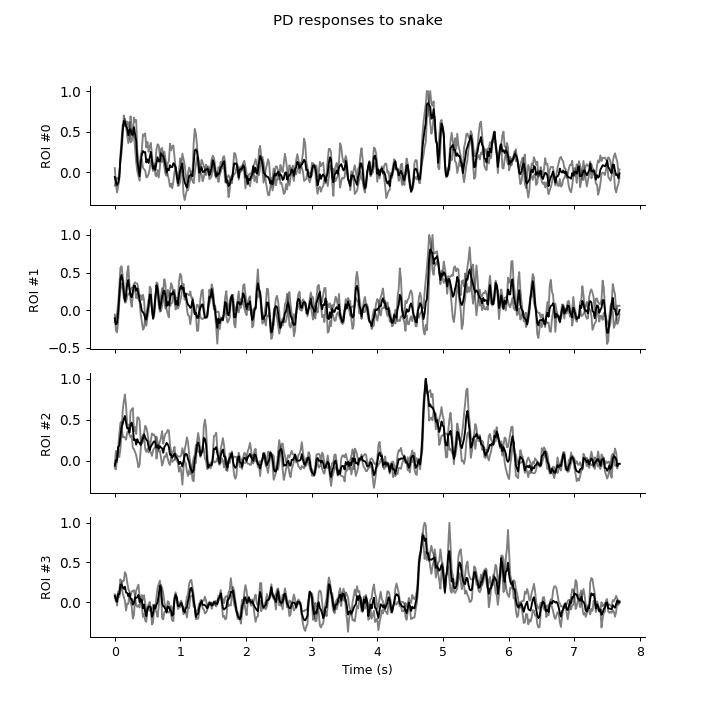

<IPython.core.display.Javascript object>


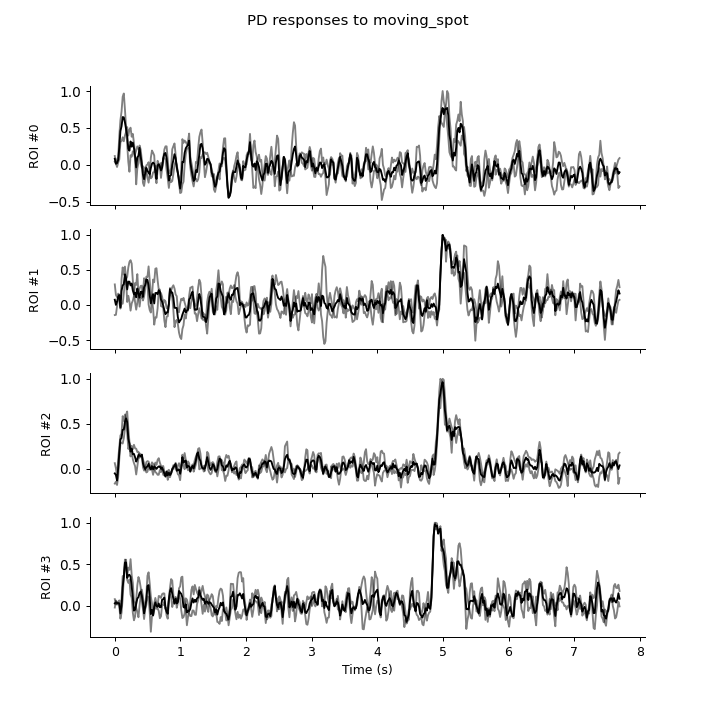

In [4]:
rec_figures = {}
for depth, stims in normed.items():
    rec_figures[depth] = {}
    for stim, rois in stims.items():
        rec_figures[stim] = {}
        rec_figures[stim]["fig"], rec_figures[stim]["ax"] = plt.subplots(
            n_rois, sharex=True, figsize=(8, 8)
        )
        for i, trials in enumerate(rois):
            for tr in trials:
                rec_figures[stim]["ax"][i].plot(rec_xaxis, tr, c="black", alpha=0.5)

            av = np.mean(trials, axis=0)
            rec_figures[stim]["ax"][i].plot(rec_xaxis, av, c="black")
            rec_figures[stim]["ax"][i].set_ylabel("ROI #%i" % i)
            clean_axes(rec_figures[stim]["ax"][i])

        rec_figures[stim]["fig"].suptitle("%s responses to %s" % (depth, stim))
        rec_figures[stim]["ax"][-1].set_xlabel("Time (s)")
        rec_figures[stim]["fig"].show()

<IPython.core.display.Javascript object>


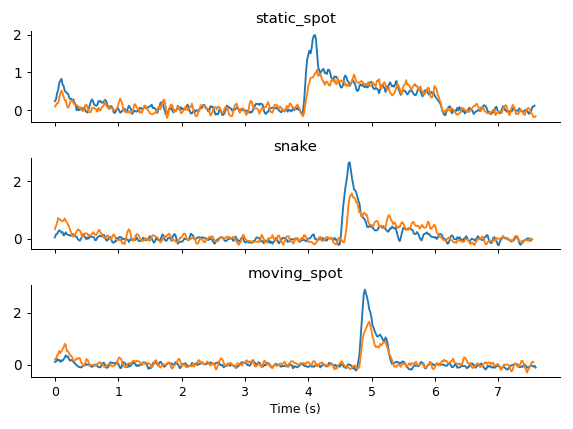

In [5]:
aligned_fig, aligned_ax = plt.subplots(len(stim_labels), sharex=True)
for depth, stims in aligned_recs.items():
    for (stim, avg), ax in zip(stims.items(), aligned_ax):
        ax.plot(np.arange(len(avg)) * dt, avg, label=depth)

for stim, ax in zip(stims.keys(), aligned_ax):        
    ax.set_title(stim)
    clean_axes(ax)

aligned_ax[-1].set_xlabel("Time (s)")
aligned_fig.tight_layout()
aligned_fig.show()

### QSE estimation from static spot responses in the proximal scan field
- steady state QSEs calculated with the relatively flat section of the responses (with the exception of the moving spot which has no such region
- base QSEs calculated from a stable window of the baseline preceding the response

In [6]:
windows = {
    "static_spot": {"steady": {0: 4.4, 1: 6.0}, "base": {0: 1., 1: 3.5}},
    "snake": {"steady": {0: 5., 1: 6.0}, "base": {0: 1.5, 1: 3.5}},
    "moving_spot": {"steady": {0: 4.8, 1: 5.3}, "base": {0: 1., 1: 4.}},
}
qses, avg_qses = {}, {}

for stim, rois in recs["PD"].items():
    qses[stim], avg_qses[stim] = [{"steady": [], "base": []} for _ in range(2)]
    steady_start = nearest_index(rec_xaxis, windows[stim]["steady"][0])
    steady_stop = nearest_index(rec_xaxis, windows[stim]["steady"][1])
    base_start = nearest_index(rec_xaxis, windows[stim]["base"][0])
    base_stop = nearest_index(rec_xaxis, windows[stim]["base"][1])
    for i, trials in enumerate(rois):
        for tr in trials:
            qses[stim]["steady"].append(quantal_size_estimate(tr[steady_start:steady_stop]))
            qses[stim]["base"].append(quantal_size_estimate(tr[base_start:base_stop]))
    
        av = np.mean(trials, axis=0)
        avg_qses[stim]["steady"].append(quantal_size_estimate(av[steady_start:steady_stop]))
        avg_qses[stim]["base"].append(quantal_size_estimate(av[base_start:base_stop]))
    
    print("Quantal Size Estimates for %s:" % stim)
    for k in qses[stim].keys():
        qses[stim][k] = np.array(qses[stim][k])
        avg_qses[stim][k] = np.array(avg_qses[stim][k])
        print("  period:", k)
        print("    per-trial:", np.round(qses[stim][k], decimals=3)) 
        print("      mean: %.3f" % np.mean(qses[stim][k]))
        print("    averaged trials:", np.round(avg_qses[stim][k], decimals=3))
        print("      mean: %.3f" % np.mean(avg_qses[stim][k]))
    print("")

Quantal Size Estimates for static_spot:
  period: steady
    per-trial: [0.403 0.203 0.373 0.491 0.372 0.287 0.335 0.236]
      mean: 0.338
    averaged trials: [0.126 0.231 0.181 0.121]
      mean: 0.165
  period: base
    per-trial: [ 3.277  2.588 55.031 39.398  2.336  5.768  1.473 -2.298]
      mean: 13.447
    averaged trials: [ 1.642 22.091  2.067  3.701]
      mean: 7.375

Quantal Size Estimates for snake:
  period: steady
    per-trial: [0.389 0.349 0.842 0.294 0.562 0.284 0.568 0.277]
      mean: 0.446
    averaged trials: [0.229 0.267 0.205 0.185]
      mean: 0.221
  period: base
    per-trial: [ -34.816    5.837   14.758    7.612   -2.086    3.202   -2.942 -180.364]
      mean: -23.600
    averaged trials: [ 7.467  5.912 -5.492 -3.748]
      mean: 1.035

Quantal Size Estimates for moving_spot:
  period: steady
    per-trial: [1.143 0.739 1.091 0.816 0.893 0.905 0.624 0.675]
      mean: 0.861
    averaged trials: [0.707 0.869 0.816 0.577]
      mean: 0.742
  period: base
    p

### Generate representative biexponential quantal event
Rough representation of an iGluSnFr mini from a bipolar terminal

using qse = 0.33758


<IPython.core.display.Javascript object>


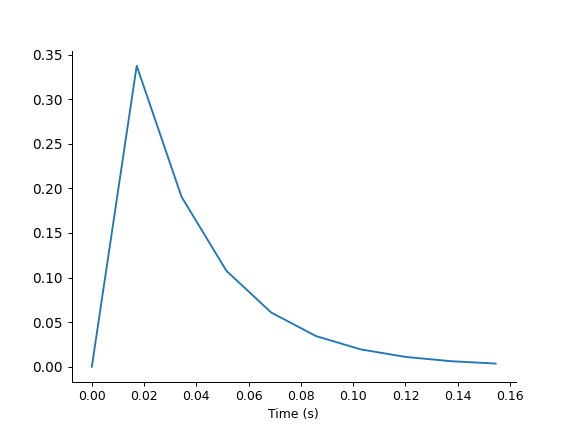

In [7]:
tau1 = 2 # rise [ms]
tau2 = 30  # decay [ms]
quantum_pts = 10

fitter = BiexpFitter(1, 10, norm_amp=True)
biexp_quantum = fitter.model(
    t=np.arange(quantum_pts), 
    tau1=tau1 / 1000 / dt, # convert to match resulting sample-rate to data
    tau2=tau2 / 1000 / dt, 
    y0=1.,
)[0]
biexp_xaxis = np.arange(quantum_pts) * dt

qse = np.mean(qses["static_spot"]["steady"])
qse_quantum = biexp_quantum * qse
print("using qse = %.5f" % qse)

biexp_fig, biexp_ax = plt.subplots(1)
biexp_ax.plot(biexp_xaxis, qse_quantum)
biexp_ax.set_xlabel("Time (s)")
clean_axes(biexp_ax)
biexp_fig.show()

### Run through quantal analysis with example waveform

In [8]:
depth = "PD"
stim = "snake"
roi_idx = 0
trial_idx = 0
ev = normed[depth][stim][roi_idx, trial_idx]
quantum_fft = np.fft.rfft(qse_quantum, n=len(ev))
rec_fft = np.fft.rfft(ev)
inv = np.fft.irfft(rec_fft / quantum_fft)
deconv = np.convolve(inv, qse_quantum)

bin_t = 0.05  # st
# bin_t = dt  # s
sz = int(bin_t / dt)
bin_edges = np.arange(sz, len(inv) + sz, sz) * dt
binned = bin_mean(inv, sz)
print("points per bin:", sz)
print("time per bin: %.2fms" % (sz * dt * 1000))

scale_mode = False
ceiling = 0.95
max_q = 5
q_scale = 1. / max_q if scale_mode else 1.

quanta = raster(binned, thresh=np.max(binned) * ceiling / max_q, max_q=max_q)    
quantal_sum = sum_quanta(quanta, bin_edges, qse_quantum * q_scale, dt)
quantal_sum_xaxis = np.arange(len(quantal_sum)) * dt

points per bin: 2
time per bin: 34.33ms


<IPython.core.display.Javascript object>


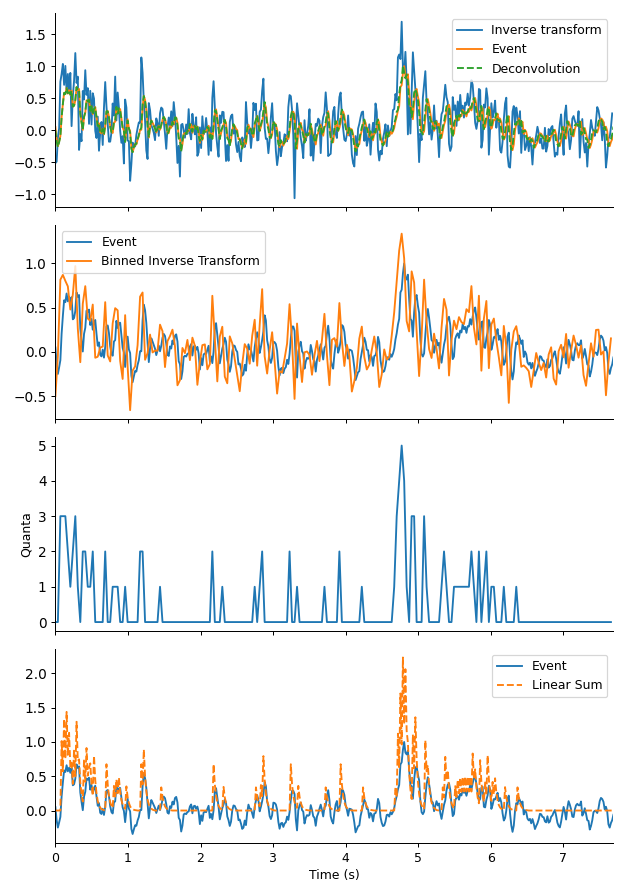

In [9]:
ex_quanta_fig, ex_quanta_ax = plt.subplots(4, sharex=True,figsize=(7, 10))

ex_quanta_ax[0].plot(rec_xaxis[:-1], inv, label="Inverse transform")
ex_quanta_ax[0].plot(rec_xaxis, ev, label="Event")
ex_quanta_ax[0].plot(np.arange(len(deconv)) * dt, deconv, label="Deconvolution", linestyle="--")
ex_quanta_ax[0].legend()

ex_quanta_ax[1].plot(rec_xaxis, ev, label="Event")
ex_quanta_ax[1].plot(bin_edges, binned, label="Binned Inverse Transform")
ex_quanta_ax[1].legend()

ex_quanta_ax[2].plot(bin_edges, quanta)
ex_quanta_ax[2].set_ylabel("Quanta")

ex_quanta_ax[3].plot(rec_xaxis, ev, label="Event")
ex_quanta_ax[3].plot(quantal_sum_xaxis, quantal_sum, label="Linear Sum", linestyle="--")
ex_quanta_ax[3].set_xlim(0, np.max(rec_xaxis))
ex_quanta_ax[3].legend()
ex_quanta_ax[3].set_xlabel("Time (s)")

for ax in ex_quanta_ax:
    clean_axes(ax)

ex_quanta_fig.tight_layout()
ex_quanta_fig.show()

### Run quantal analysis on all recordings
- All trials, of all ROIs, from both proximal and distal scan fields
- Run through with a range of maximum quanta count (`max_q`) values

In [10]:
def quantify(data, bin_t=0.05, ceiling=0.95, max_q=5, scale_mode=False):
    res = {}
    for depth, stims in data.items():
        res[depth] = {}
        for stim, rois in stims.items():
            res[depth][stim] = {}
            (
                res[depth][stim]["quanta"], 
                res[depth][stim]["quanta_xaxis"], 
                res[depth][stim]["quantal_sum"],
                res[depth][stim]["quantal_sum_xaxis"],
            ) = get_quanta(
                    rois, 
                    qse_quantum, 
                    dt, 
                    bin_t=bin_t,
                    ceiling=ceiling,
                    max_q=max_q,
                    scale_mode=scale_mode
                )
    return res

quantifications = {i: quantify(recs, max_q=i, scale_mode=False) for i in range(1, 15)}
aligned_quants = {i: quantify(aligned_recs, max_q=i, scale_mode=False) for i in range(1, 15)}

### Calculate Mean Squared Error to see how the quantal sums fit to the original data depends on the maximum number of quanta per time bin

<IPython.core.display.Javascript object>


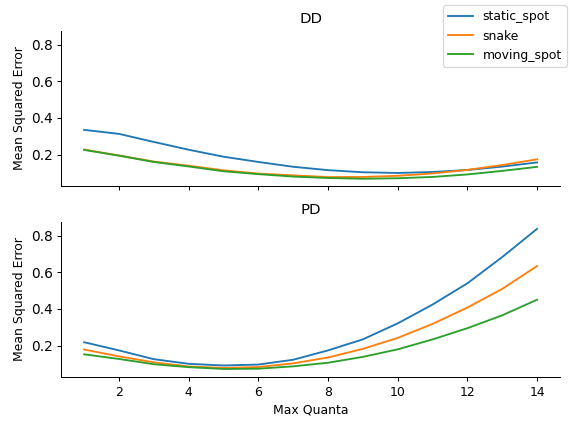

In [11]:
mses = {d: {s: [] for s in stim_labels} for d in ["DD", "PD"]}
for n, data in quantifications.items():
    for depth, stims in data.items():
        for stim, quants in stims.items():
            r = recs[depth][stim]
            diff = r - quants["quantal_sum"][:, :, :r.shape[-1]]  # truncate to same shape
            mses[depth][stim].append(np.mean(diff ** 2))

mse_xaxis = np.array(list(quantifications.keys()))
mses = {d: {s: np.array(es) for s, es in stims.items()} for d, stims in mses.items()}

mse_fig, mse_ax = plt.subplots(2, sharex=True, sharey=True)
for i, ((depth, stims), ax) in enumerate(zip(mses.items(), mse_ax)):
    for stim, errors in stims.items():
        lbl = stim if not i else None
        ax.plot(mse_xaxis, errors, label=lbl)
    
    ax.set_title(depth)
    ax.set_ylabel("Mean Squared Error")
    clean_axes(ax)

mse_ax[-1].set_xlabel("Max Quanta")
mse_fig.legend()
mse_fig.tight_layout()
mse_fig.show()

<IPython.core.display.Javascript object>


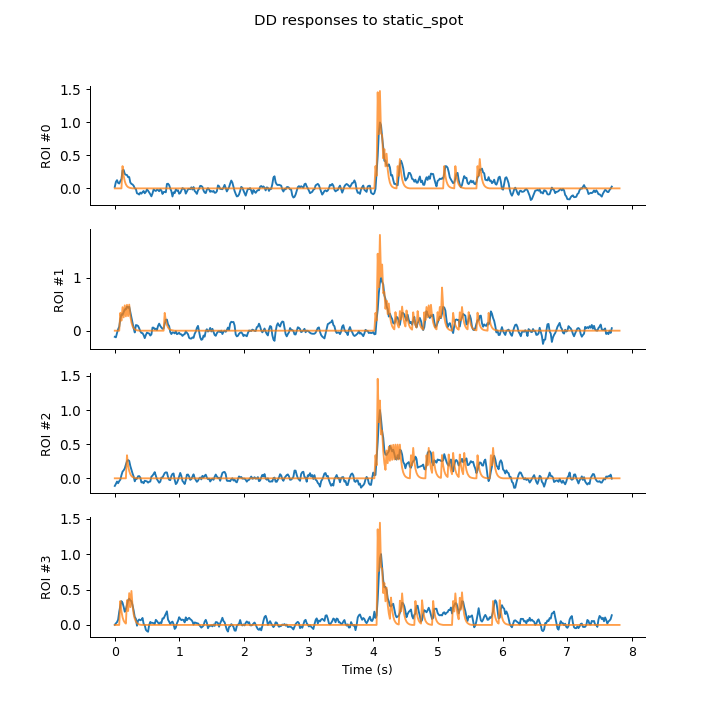

<IPython.core.display.Javascript object>


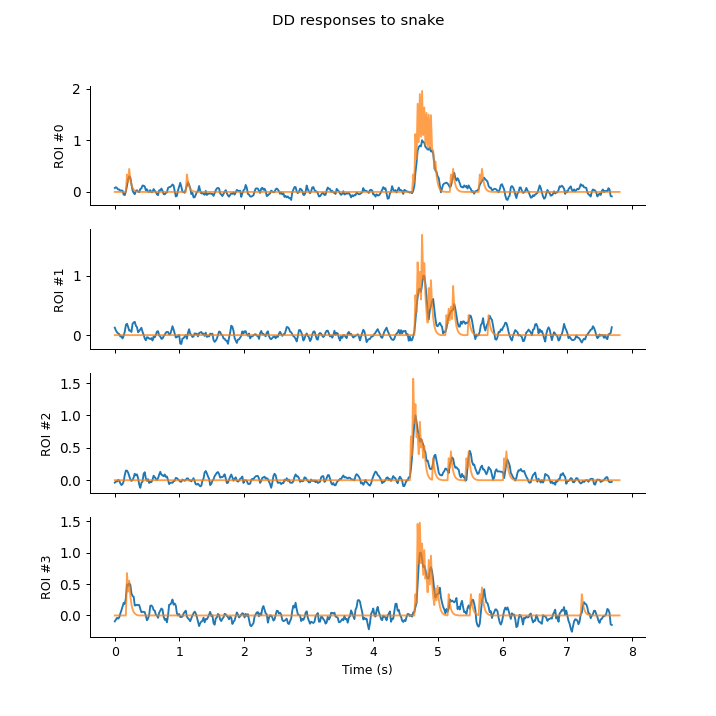

<IPython.core.display.Javascript object>


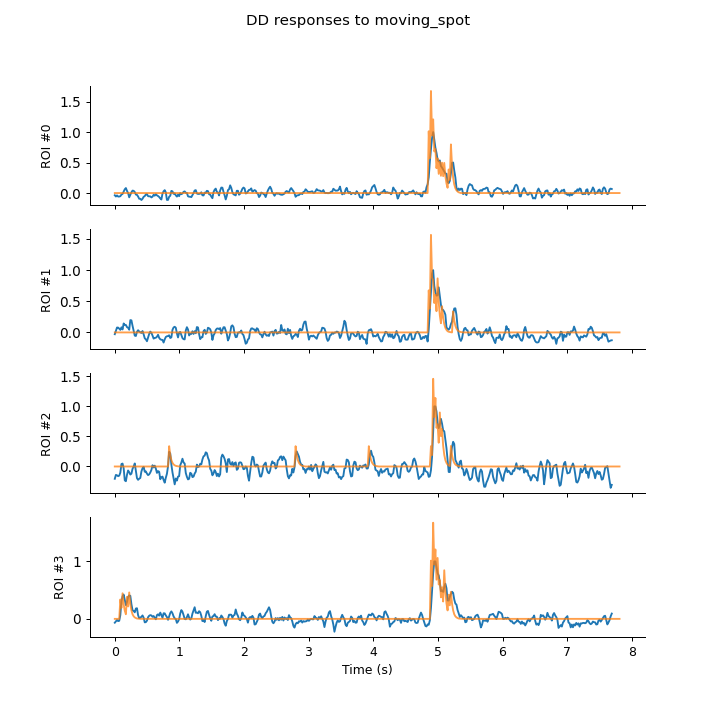

<IPython.core.display.Javascript object>


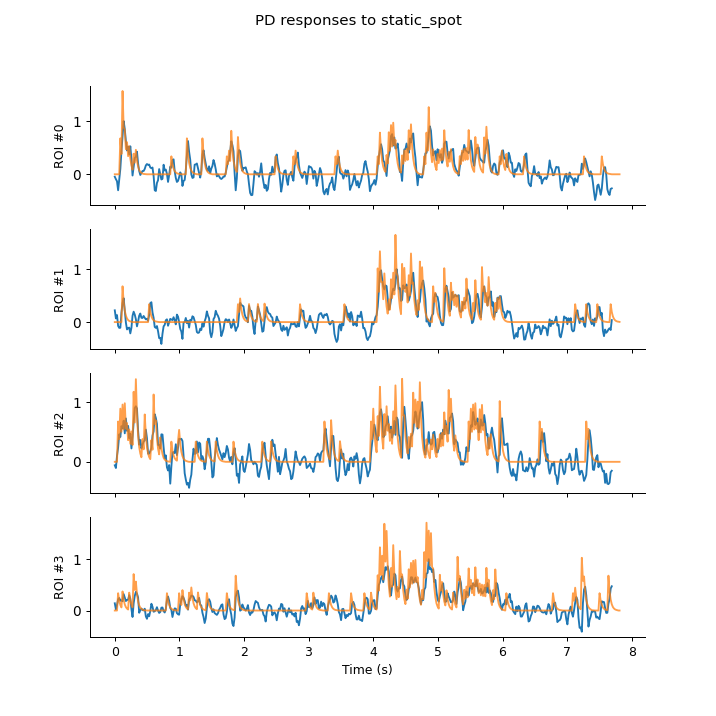

<IPython.core.display.Javascript object>


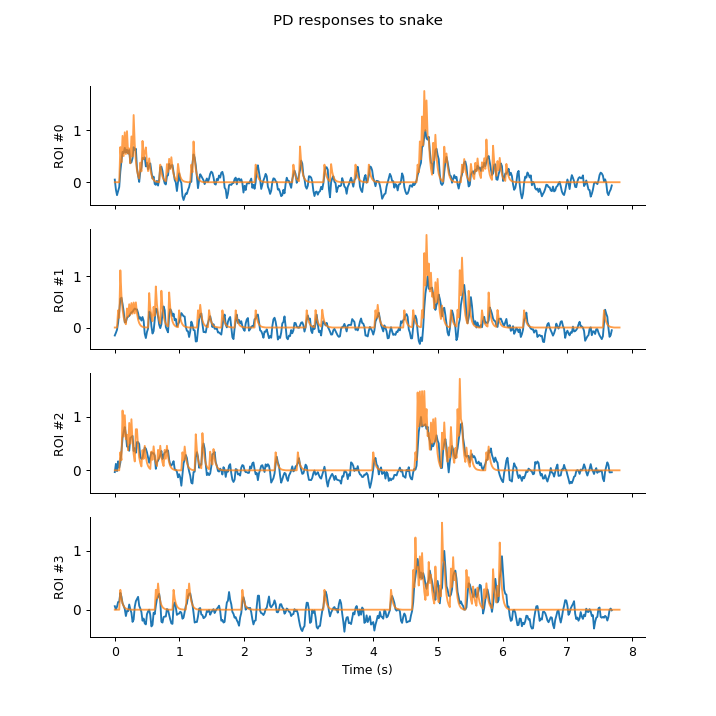

<IPython.core.display.Javascript object>


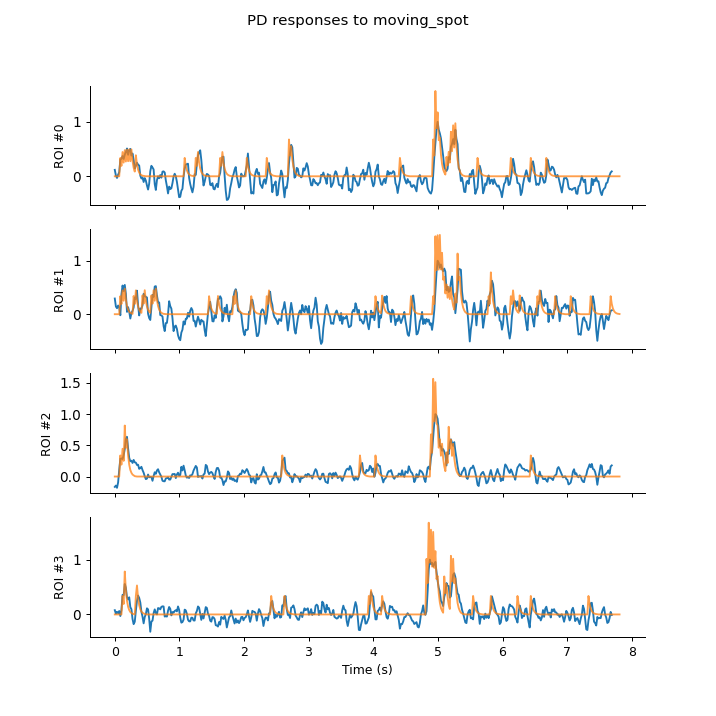

In [21]:
max_q = 4
trial_idx = 0
quants = quantifications[max_q]

quanta_figures = {}
for depth, stims in normed.items():
    quanta_figures[depth] = {}
    for stim, rois in stims.items():
        quanta_figures[stim] = {}
        quanta_figures[stim]["fig"], quanta_figures[stim]["ax"] = plt.subplots(
            n_rois, sharex=True, figsize=(8, 8)
        )
        roi = np.mean(rois, axis=1) if trial_idx is None else rois[:, trial_idx]
        for i, tr in enumerate(roi):
            quanta_figures[stim]["ax"][i].plot(
                rec_xaxis, tr, label="Event" if not i else None)
            qsum = (np.mean(quants[depth][stim]["quantal_sum"][i], axis=0)
                    if trial_idx is None
                    else quants[depth][stim]["quantal_sum"][i, trial_idx])
            quanta_figures[stim]["ax"][i].plot(
                quants[depth][stim]["quantal_sum_xaxis"], 
                qsum, 
                alpha=0.75, 
                label="Quantal Sum" if not i else None
            )
            quanta_figures[stim]["ax"][i].set_ylabel("ROI #%i" % i)
            clean_axes(quanta_figures[stim]["ax"][i])

        quanta_figures[stim]["fig"].suptitle("%s responses to %s" % (depth, stim))
        quanta_figures[stim]["ax"][-1].set_xlabel("Time (s)")
        quanta_figures[stim]["fig"].show()

<IPython.core.display.Javascript object>


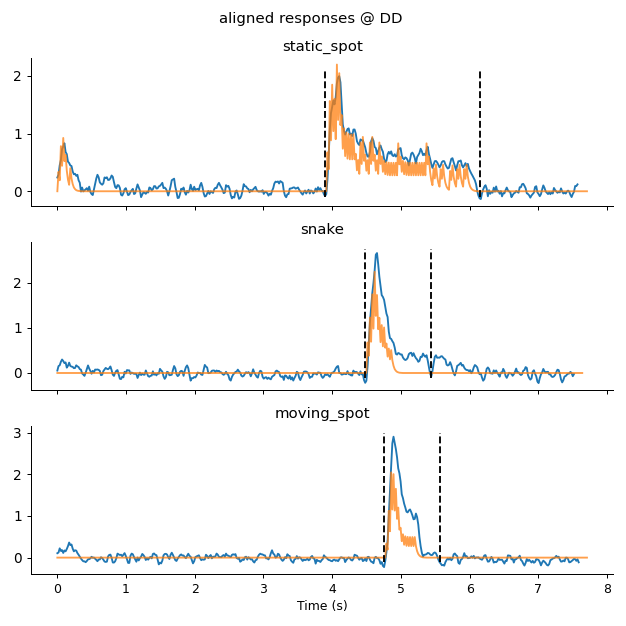

<IPython.core.display.Javascript object>


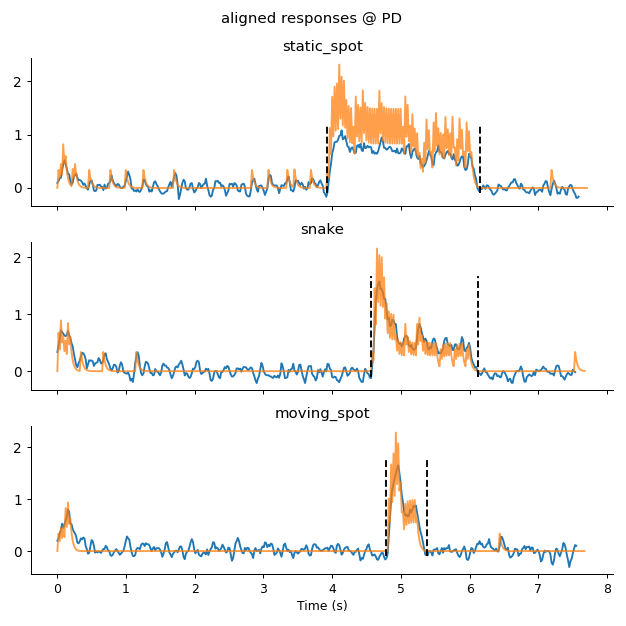

In [39]:
max_q = 5
aligned_qs = aligned_quants[max_q]
mark_ends = True
mark_peak = True

aligned_q_figs = {}
for depth, stims in aligned_qs.items():
    aligned_q_figs[depth] = {}
    aligned_q_figs[depth]["fig"], aligned_q_figs[depth]["ax"] = plt.subplots(
        len(stim_labels), sharex=True, figsize=(7, 7)
    )
    for (stim, qs), ax in zip(stims.items(), aligned_q_figs[depth]["ax"]):
        avg = aligned_recs[depth][stim]
        ax.plot(np.arange(len(avg)) * dt, avg)
        ax.plot(qs["quantal_sum_xaxis"], qs["quantal_sum"], alpha=0.75)
        if mark_ends:
            rise_idx = find_rise_bsln(avg, bsln_start=100, bsln_end=150, step=2)
            rise_t = rise_idx * dt
            ax.plot([rise_t, rise_t], [-0.1, np.max(avg) + 0.1], linestyle="--", c="black")
            fall_idx = find_bsln_return(avg, bsln_start=100, bsln_end=150, offset=-0.01, step=5)
            fall_t = fall_idx * dt
            ax.plot([fall_t, fall_t], [-0.1, np.max(avg) + 0.1], linestyle="--", c="black")
        ax.set_title(stim)
        clean_axes(ax)
        
    aligned_q_figs[depth]["fig"].suptitle("aligned responses @ %s " % depth)
    aligned_q_figs[depth]["ax"][-1].set_xlabel("Time (s)")
    aligned_q_figs[depth]["fig"].tight_layout()
    aligned_q_figs[depth]["fig"].show()

In [14]:
q_counts = quants["PD"]["snake"]["quanta"]
q_xaxis = quants["PD"]["snake"]["quanta_xaxis"]

In [15]:
# TODO: should use the new generator class way that numpy encourages. Create a py_rng
# object with a seed (as done for hoc random) that is used for number pulling on the 
# python side.
def poisson_quanta(rate, dt, duration):
    n = int(duration / dt)
    return np.random.poisson(lam=dt * rate, size=n)

def quanta_to_times(qs, dt):
    ts = []
    t = 0.
    for n in qs:
        for _ in range(n):
            ts.append(t)
        t += dt
    return np.array(ts)

def times_to_quanta(ts, dt, duration):
    counts, _edges = np.histogram(ts, bins=int(duration / dt))
    return counts

def poisson_bipolar(trans_rate, trans_dur, sust_rate, sust_dur, dt):
    trans = poisson_quanta(trans_rate, dt, trans_dur)
    sust = poisson_quanta(sust_rate, dt, sust_dur)
    return np.concatenate([trans, sust])

def poisson_of_release(rate):
    return np.array([np.random.poisson(lam=max(r, 0.), size=1) for r in rate])

In [16]:
delta = 0.1
duration = 10
n = int(duration / delta)
x = np.arange(n) * delta
pq = poisson_quanta(5, delta, duration)
qts = quanta_to_times(pq, delta)
requantize = times_to_quanta(qts, delta, duration)
bi_pq = poisson_bipolar(20, 1, 5, 5, 0.01)
print("total quanta:", np.sum(pq))

total quanta: 52


<IPython.core.display.Javascript object>


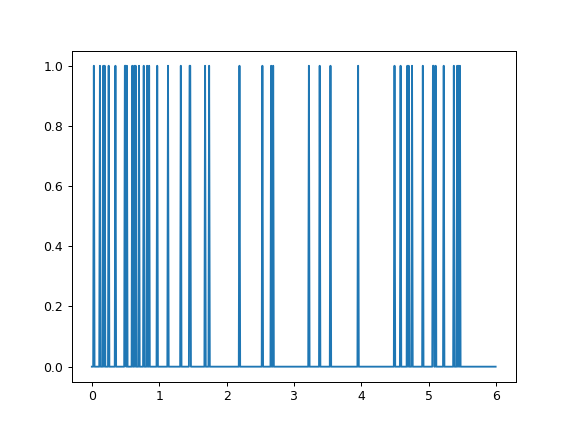

In [17]:
fff, aaa = plt.subplots(1)
aaa.plot(np.arange(len(bi_pq)) * 0.01, bi_pq)

<IPython.core.display.Javascript object>


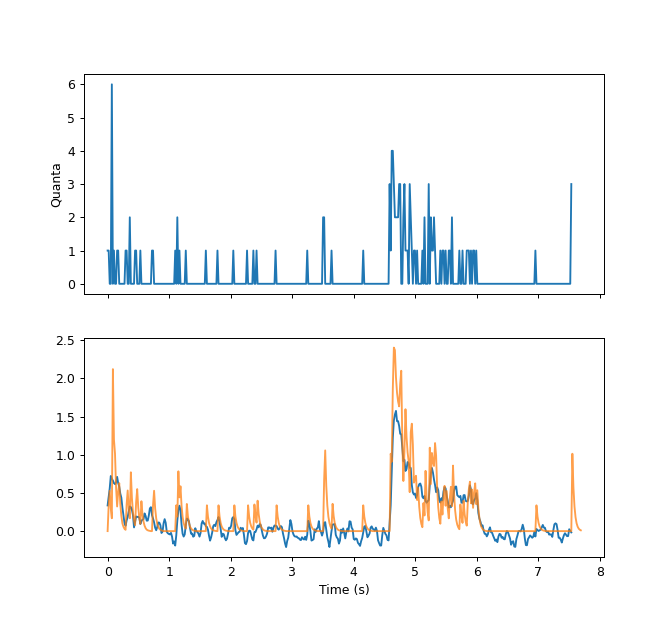

In [30]:
depth = "PD"
stim = "snake"
roi_idx = None
ex = aligned_recs[depth][stim] if roi_idx is None else avg_recs[depth][stim][roi_idx]
avg_inv = np.fft.irfft(
    np.fft.rfft(ex) / np.fft.rfft(qse_quantum, n=len(ex))
)

rpq = poisson_of_release(avg_inv)
rpq_sum = sum_quanta(rpq, np.arange(len(rpq)) * dt, qse_quantum, dt)
rpq_sum_xaxis = np.arange(len(rpq_sum)) * dt

rate_poisson_fig, rate_poisson_ax = plt.subplots(2, sharex=True, figsize=(7.5, 7))
rate_poisson_ax[0].plot(np.arange(len(rpq)) * dt, rpq)
rate_poisson_ax[0].set_ylabel("Quanta")
rate_poisson_ax[1].plot(np.arange(len(ex)) * dt, ex)
rate_poisson_ax[1].plot(rpq_sum_xaxis, rpq_sum, alpha=0.75)
rate_poisson_ax[1].set_xlabel("Time (s)")
rate_poisson_fig.show()

In [31]:
aligned_rates = {
    d: {
        s: np.fft.irfft(np.fft.rfft(r) / np.fft.rfft(qse_quantum, n=len(r)))
        for s, r in stims.items()
    }
    for d, stims in aligned_recs.items()
}

# TODO: clip using the length of the PD responses?
# TODO: clip using the savgol of the rate?
extra_lead = 0
extra_tail = 5
clipped_aligned_rates = {
    d: {
        s: r[
            find_rise_bsln(r, bsln_start=100, bsln_end=150, step=1) - extra_lead:
            find_bsln_return(
                r, bsln_start=100, bsln_end=150, offset=-0.1, step=5) + extra_tail
        ]
        for s, r in stims.items()
    }
    for d, stims in aligned_recs.items()
}

<IPython.core.display.Javascript object>


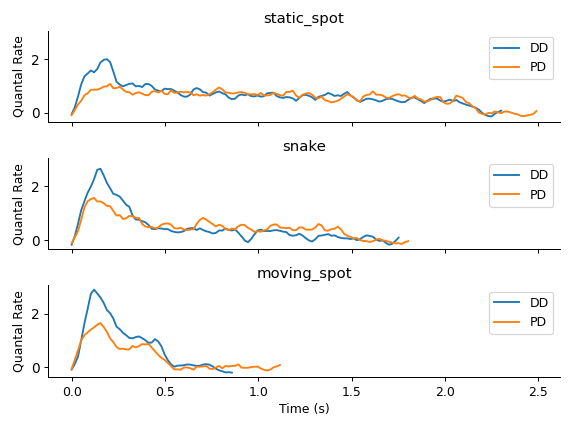

In [41]:
clipped_rate_fig, clipped_rate_ax = plt.subplots(len(stim_labels), sharex=True, sharey=True)
for depth, stims in clipped_aligned_rates.items():
    for ax, (stim, rate) in zip(clipped_rate_ax, stims.items()):
        ax.plot(np.arange(len(rate)) * dt, rate, label=depth)

for ax, stim in zip(clipped_rate_ax, stims.keys()):
    ax.legend()
    ax.set_title(stim)
    ax.set_ylabel("Quantal Rate")
    clean_axes(ax)

clipped_rate_ax[-1].set_xlabel("Time (s)")
clipped_rate_fig.tight_layout()
clipped_rate_fig.show()